In [8]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [9]:
data = pd.read_excel("/Users/yj.noh/Desktop/churn_rider.xlsx")
print(data.head(2))
print(data.shape) #10,597

          brms_rider_id     max_day  cnt_ord  sum_fee  not_period
0  23082166675842492513  2023-10-10      862  4365340          55
1  23071565348654700880  2023-10-20       80   333460          45
(10597, 5)


# 2. matching - 층화추출

In [10]:
# cnt_ord, sum_fee, not_period 층화추출하기 
data['cnt_ord_group'] = pd.qcut(data['cnt_ord'], 5, labels=False)
data['sum_fee_group'] = pd.qcut(data['sum_fee'], 5, labels=False)
data['not_period_group'] = pd.qcut(data['not_period'], 5, labels=False)

print(data['cnt_ord_group'].value_counts())
print(data['sum_fee_group'].value_counts())
print(data['not_period_group'].value_counts())

cnt_ord_group
0    2214
3    2130
4    2107
1    2076
2    2070
Name: count, dtype: int64
sum_fee_group
4    2120
0    2120
3    2119
2    2119
1    2119
Name: count, dtype: int64
not_period_group
0    2404
3    2210
1    2049
2    2031
4    1903
Name: count, dtype: int64


In [12]:
# 층화추출을 위한 조합 생성
strata = data.groupby(['cnt_ord_group', 'sum_fee_group', 'not_period_group'])

# 각 조합별로 실험군과 대조군 생성
stratified_samples = []
for _, group_data in strata:
    # 그룹의 크기가 1보다 큰 경우에만 분할
    if len(group_data) > 1:
        experimental, control = train_test_split(group_data, test_size=0.5, random_state=42)
        experimental['group'] = 'experimental'
        control['group'] = 'control'
        stratified_samples.append(experimental)
        stratified_samples.append(control)
    else:
        # 그룹의 크기가 1인 경우, 해당 샘플을 한 번만 추가
        group_data['group'] = 'single_sample'
        stratified_samples.append(group_data)

# 모든 층화된 샘플을 하나의 DataFrame으로 결합
stratified_data = pd.concat(stratified_samples)

# 결과 확인
print(stratified_data[['brms_rider_id', 'cnt_ord', 'cnt_ord_group', 'sum_fee', 'sum_fee_group', 'not_period','not_period_group', 'group']].head())
print(stratified_data.shape) #16671


              brms_rider_id  cnt_ord  cnt_ord_group  sum_fee  sum_fee_group  \
9050   21123171787420922345       17              0    78320              0   
10080  23092481612357349476       15              0    57810              0   
5934   22012186242836922704       12              0    37040              0   
6043   21073120269579477320       12              0    59100              0   
8178   23081334801164227612       18              0    69020              0   

       not_period  not_period_group         group  
9050           31                 0  experimental  
10080          29                 0  experimental  
5934           32                 0  experimental  
6043           28                 0  experimental  
8178           31                 0  experimental  
(10597, 9)


In [13]:
stratified_data['group'].value_counts()

group
control          5315
experimental     5280
single_sample       2
Name: count, dtype: int64

In [14]:
final_df = stratified_data[stratified_data['group'].isin(['control', 'experimental'])]
print(final_df.shape) #10,595

(10595, 9)


In [15]:
print(final_df.isna().sum())

brms_rider_id       0
max_day             0
cnt_ord             0
sum_fee             0
not_period          0
cnt_ord_group       0
sum_fee_group       0
not_period_group    0
group               0
dtype: int64


In [16]:
numerical_columns = ['cnt_ord', 'sum_fee', 'not_period']

# 수치형 변수에 대한 t-test 및 Wilcoxon rank sum test
for col in numerical_columns:
    control = final_df[final_df['group'] == 'control'][col]
    experimental = final_df[final_df['group'] == 'experimental'][col]

    ttest_pvalue = stats.ttest_ind(control, experimental, equal_var=False).pvalue
    wilcoxon_pvalue = stats.ranksums(control, experimental).pvalue

    print(f"{col} - t-test p-value: {ttest_pvalue}")
    print(f"{col} - Wilcoxon rank sum test p-value: {wilcoxon_pvalue}")

cnt_ord - t-test p-value: 0.7578602557162228
cnt_ord - Wilcoxon rank sum test p-value: 0.9204835369834139
sum_fee - t-test p-value: 0.9043745308520339
sum_fee - Wilcoxon rank sum test p-value: 0.8081731873233327
not_period - t-test p-value: 0.8473220508151247
not_period - Wilcoxon rank sum test p-value: 0.8516571318285655


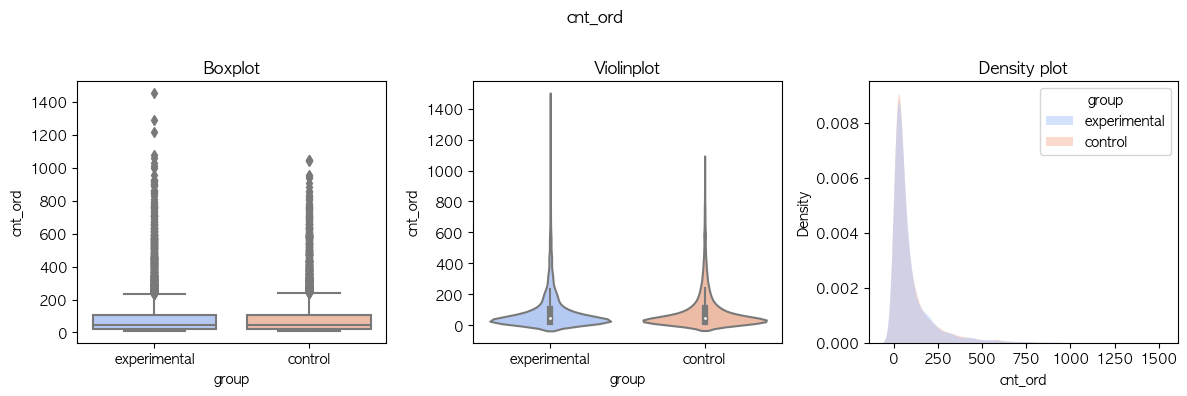

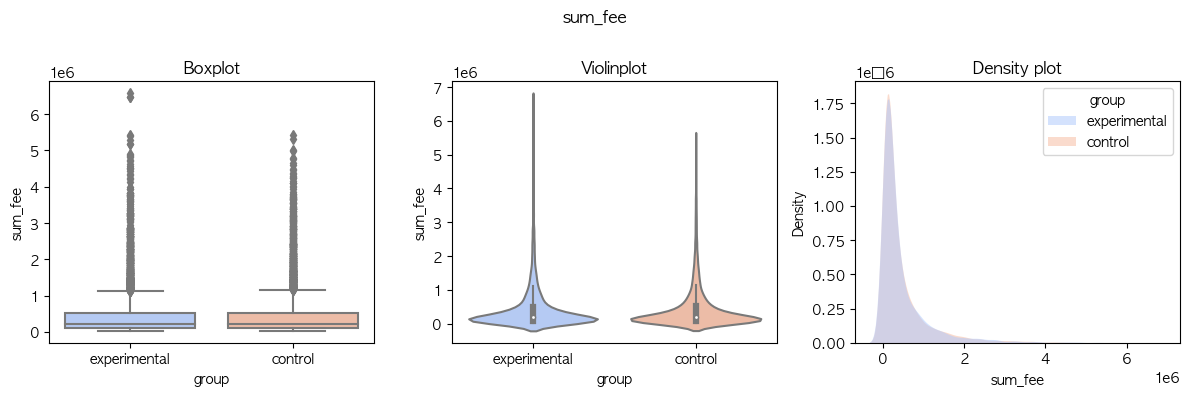

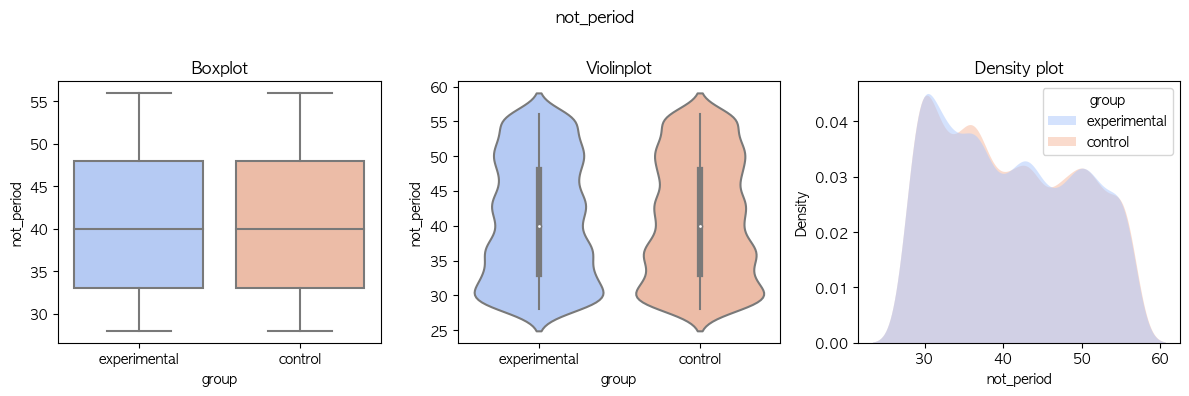

In [18]:
def plot_numeric (data, numeric_vars, outcome):
    
    palette = 'coolwarm'
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        fig.suptitle(f'{num_var}', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) 
        plt.show()
        plt.close(fig)

plot_numeric(final_df, numerical_columns, 'group')

In [23]:
data_df = final_df[final_df['group'] == 'experimental']
data_df = data_df[['brms_rider_id', 'cnt_ord', 'sum_fee']]
print(data_df.shape)
data_df.to_excel ("/Users/yj.noh/Desktop/test_set.xlsx", index = False, header=['brms_rider_id','건', '원'])

(5280, 3)
